TOURISM ANALYTICS - RECOMMENDATION SYSTEM DEVELOPMENT

1. DATA LOADING AND PREPARATION
--------------------------------------------------
Looking for processed data at: ../data/processed/
✓ Master dataset loaded: (14185, 54)
✓ Pre-processed recommendation data loaded
  User-item matrix: (9688, 30)
  Recommendation data: (14185, 3)

📊 RECOMMENDATION DATA ANALYSIS:
----------------------------------------
Users: 9,688
Attractions: 30
Total possible interactions: 290,640
Actual interactions: 12,449
Sparsity: 95.72%

User interaction statistics:
  Mean interactions per user: 1.3
  Median interactions per user: 1.0
  Users with single interaction: 7,642
  Users with 5+ interactions: 30

Attraction interaction statistics:
  Mean interactions per attraction: 415.0
  Median interactions per attraction: 81.0
  Attractions with single interaction: 1
  Attractions with 10+ interactions: 25

2. DATA SPLITTING FOR RECOMMENDATION EVALUATION
--------------------------------------------------
Filtered

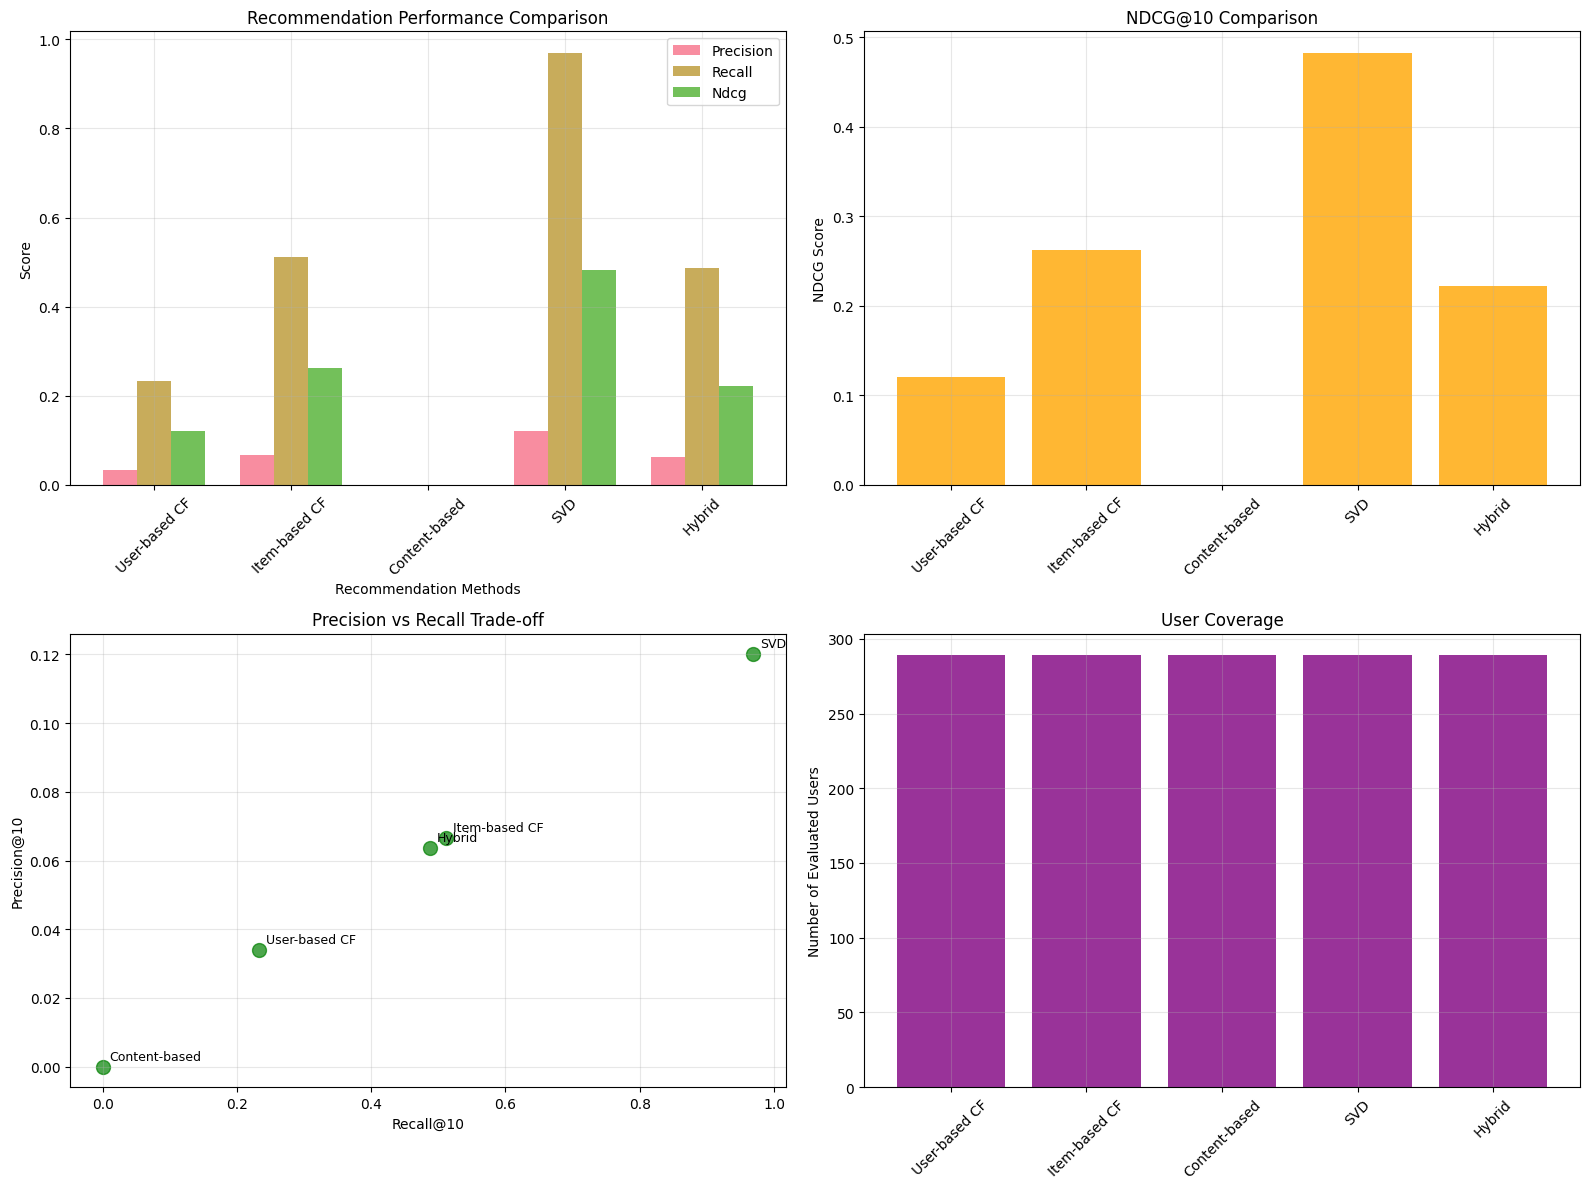

✓ Evaluation results saved as 'recommendation_evaluation_results.png'

9. RECOMMENDATION DIVERSITY AND NOVELTY ANALYSIS
--------------------------------------------------
Analyzing recommendation diversity...

📊 RECOMMENDATION DIVERSITY ANALYSIS:
               unique_items  catalog_coverage  avg_popularity  avg_novelty  \
User-based CF          20.0            71.429          20.513        0.324   
Item-based CF          25.0            89.286          42.412        0.319   
Content-based          10.0            35.714           0.000        0.000   
SVD                    15.0            53.571          77.728        0.139   
Hybrid                 22.0            78.571          45.024        0.291   

               evaluated_users  
User-based CF            100.0  
Item-based CF            100.0  
Content-based            100.0  
SVD                      100.0  
Hybrid                   100.0  

10. MODEL SAVING AND DEPLOYMENT PREPARATION
-----------------------------------------

In [2]:
# Tourism Experience Analytics - Recommendation System
# Step 5: Collaborative Filtering, Content-Based, and Hybrid Recommendations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from datetime import datetime
import joblib
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("=" * 80)
print("TOURISM ANALYTICS - RECOMMENDATION SYSTEM DEVELOPMENT")
print("=" * 80)

# =============================================================================
# SECTION 1: DATA LOADING AND PREPARATION
# =============================================================================

print("\n1. DATA LOADING AND PREPARATION")
print("-" * 50)

# Auto-detect processed data path
current_dir = os.getcwd()
if 'notebooks' in current_dir:
    processed_path = '../data/processed/'
else:
    processed_path = 'data/processed/'

print(f"Looking for processed data at: {processed_path}")

# Load processed datasets
try:
    master_df = pd.read_csv(processed_path + 'master_dataset.csv')
    print(f"✓ Master dataset loaded: {master_df.shape}")
    
    # Try to load recommendation-specific data
    try:
        user_item_matrix = pd.read_csv(processed_path + 'user_item_matrix.csv', index_col=0)
        recommendation_data = pd.read_csv(processed_path + 'recommendation_data.csv')
        print(f"✓ Pre-processed recommendation data loaded")
        print(f"  User-item matrix: {user_item_matrix.shape}")
        print(f"  Recommendation data: {recommendation_data.shape}")
        use_prebuilt = True
    except FileNotFoundError:
        print("Pre-processed recommendation data not found, will create from master dataset")
        use_prebuilt = False
        
except FileNotFoundError:
    print("❌ Processed data not found. Please run Step 2 (Data Preprocessing) first.")
    exit()

# Prepare recommendation data
if not use_prebuilt:
    # Create user-item matrix from master dataset
    print("\nCreating user-item matrix from master dataset...")
    
    # Essential columns for recommendations
    required_cols = ['UserId', 'AttractionId', 'Rating']
    if not all(col in master_df.columns for col in required_cols):
        print(f"❌ Required columns missing: {[col for col in required_cols if col not in master_df.columns]}")
        exit()
    
    recommendation_data = master_df[required_cols].copy()
    
    # Remove any missing values
    recommendation_data = recommendation_data.dropna()
    print(f"Recommendation data shape after cleaning: {recommendation_data.shape}")
    
    # Create user-item matrix
    user_item_matrix = recommendation_data.pivot_table(
        index='UserId', 
        columns='AttractionId', 
        values='Rating', 
        fill_value=0
    )
    print(f"User-item matrix created: {user_item_matrix.shape}")

# Analyze recommendation data characteristics
print(f"\n📊 RECOMMENDATION DATA ANALYSIS:")
print("-" * 40)

print(f"Users: {len(user_item_matrix.index):,}")
print(f"Attractions: {len(user_item_matrix.columns):,}")
print(f"Total possible interactions: {len(user_item_matrix.index) * len(user_item_matrix.columns):,}")

# Calculate sparsity
total_cells = user_item_matrix.shape[0] * user_item_matrix.shape[1]
non_zero_cells = (user_item_matrix > 0).sum().sum()
sparsity = (1 - non_zero_cells / total_cells) * 100

print(f"Actual interactions: {non_zero_cells:,}")
print(f"Sparsity: {sparsity:.2f}%")

# User and item statistics
user_interaction_counts = (user_item_matrix > 0).sum(axis=1)
item_interaction_counts = (user_item_matrix > 0).sum(axis=0)

print(f"\nUser interaction statistics:")
print(f"  Mean interactions per user: {user_interaction_counts.mean():.1f}")
print(f"  Median interactions per user: {user_interaction_counts.median():.1f}")
print(f"  Users with single interaction: {(user_interaction_counts == 1).sum():,}")
print(f"  Users with 5+ interactions: {(user_interaction_counts >= 5).sum():,}")

print(f"\nAttraction interaction statistics:")
print(f"  Mean interactions per attraction: {item_interaction_counts.mean():.1f}")
print(f"  Median interactions per attraction: {item_interaction_counts.median():.1f}")
print(f"  Attractions with single interaction: {(item_interaction_counts == 1).sum():,}")
print(f"  Attractions with 10+ interactions: {(item_interaction_counts >= 10).sum():,}")

# =============================================================================
# SECTION 2: DATA SPLITTING FOR RECOMMENDATION EVALUATION
# =============================================================================

print("\n2. DATA SPLITTING FOR RECOMMENDATION EVALUATION")
print("-" * 50)

# Filter users and items with minimum interactions for reliable evaluation
min_user_interactions = 3
min_item_interactions = 3

# Filter users
active_users = user_interaction_counts[user_interaction_counts >= min_user_interactions].index
filtered_user_item_matrix = user_item_matrix.loc[active_users]

# Filter items
popular_items = item_interaction_counts[item_interaction_counts >= min_item_interactions].index
filtered_user_item_matrix = filtered_user_item_matrix[popular_items]

print(f"Filtered matrix shape: {filtered_user_item_matrix.shape}")
print(f"Filtered users: {len(active_users):,}")
print(f"Filtered attractions: {len(popular_items):,}")

# Create train-test split for recommendation evaluation
np.random.seed(42)

# Convert to long format for splitting
interactions = []
for user_id in filtered_user_item_matrix.index:
    for item_id in filtered_user_item_matrix.columns:
        rating = filtered_user_item_matrix.loc[user_id, item_id]
        if rating > 0:
            interactions.append({'UserId': user_id, 'AttractionId': item_id, 'Rating': rating})

interactions_df = pd.DataFrame(interactions)
print(f"Total interactions for evaluation: {len(interactions_df):,}")

# Split interactions (80% train, 20% test)
# Remove stratification if ratings have insufficient samples per class
rating_counts = interactions_df['Rating'].value_counts()
min_rating_count = rating_counts.min()

if min_rating_count < 2:
    print(f"Warning: Some ratings have only {min_rating_count} sample(s), using random split without stratification")
    train_interactions, test_interactions = train_test_split(
        interactions_df, test_size=0.2, random_state=42
    )
else:
    train_interactions, test_interactions = train_test_split(
        interactions_df, test_size=0.2, random_state=42, stratify=interactions_df['Rating']
    )

print(f"Training interactions: {len(train_interactions):,}")
print(f"Testing interactions: {len(test_interactions):,}")

# Create training matrix
train_matrix = pd.DataFrame(0, index=filtered_user_item_matrix.index, columns=filtered_user_item_matrix.columns)
for _, row in train_interactions.iterrows():
    train_matrix.loc[row['UserId'], row['AttractionId']] = row['Rating']

print(f"Training matrix shape: {train_matrix.shape}")
print(f"Training matrix sparsity: {((train_matrix == 0).sum().sum() / train_matrix.size * 100):.2f}%")

# =============================================================================
# SECTION 3: COLLABORATIVE FILTERING IMPLEMENTATION
# =============================================================================

print("\n3. COLLABORATIVE FILTERING IMPLEMENTATION")
print("-" * 50)

class CollaborativeFiltering:
    def __init__(self, method='user_based', n_neighbors=50, min_similarity=0.1):
        self.method = method
        self.n_neighbors = n_neighbors
        self.min_similarity = min_similarity
        self.user_similarity = None
        self.item_similarity = None
        self.train_matrix = None
        
    def fit(self, train_matrix):
        """Fit the collaborative filtering model"""
        self.train_matrix = train_matrix
        
        if self.method == 'user_based':
            print("Computing user-based similarities...")
            # Calculate user-user similarity
            user_matrix = train_matrix.values
            self.user_similarity = cosine_similarity(user_matrix)
            self.user_similarity = pd.DataFrame(
                self.user_similarity, 
                index=train_matrix.index, 
                columns=train_matrix.index
            )
            
        elif self.method == 'item_based':
            print("Computing item-based similarities...")
            # Calculate item-item similarity
            item_matrix = train_matrix.T.values
            self.item_similarity = cosine_similarity(item_matrix)
            self.item_similarity = pd.DataFrame(
                self.item_similarity,
                index=train_matrix.columns,
                columns=train_matrix.columns
            )
        
        print(f"✓ {self.method} collaborative filtering model fitted")
    
    def predict_rating(self, user_id, item_id):
        """Predict rating for a user-item pair"""
        if user_id not in self.train_matrix.index or item_id not in self.train_matrix.columns:
            return self.train_matrix.values[self.train_matrix.values > 0].mean()
        
        if self.method == 'user_based':
            return self._predict_user_based(user_id, item_id)
        elif self.method == 'item_based':
            return self._predict_item_based(user_id, item_id)
    
    def _predict_user_based(self, user_id, item_id):
        """User-based collaborative filtering prediction"""
        # Get users who rated this item
        users_who_rated = self.train_matrix[self.train_matrix[item_id] > 0].index
        
        if len(users_who_rated) == 0:
            return self.train_matrix.values[self.train_matrix.values > 0].mean()
        
        # Get similarities with these users
        similarities = self.user_similarity.loc[user_id, users_who_rated]
        similarities = similarities[similarities >= self.min_similarity]
        
        if len(similarities) == 0:
            return self.train_matrix.values[self.train_matrix.values > 0].mean()
        
        # Get top similar users
        top_similar = similarities.nlargest(self.n_neighbors)
        
        # Calculate weighted average
        weighted_sum = 0
        weight_sum = 0
        
        for similar_user, similarity in top_similar.items():
            rating = self.train_matrix.loc[similar_user, item_id]
            weighted_sum += similarity * rating
            weight_sum += abs(similarity)
        
        if weight_sum == 0:
            return self.train_matrix.values[self.train_matrix.values > 0].mean()
        
        return weighted_sum / weight_sum
    
    def _predict_item_based(self, user_id, item_id):
        """Item-based collaborative filtering prediction"""
        # Get items rated by this user
        items_rated_by_user = self.train_matrix.loc[user_id][self.train_matrix.loc[user_id] > 0].index
        
        if len(items_rated_by_user) == 0:
            return self.train_matrix.values[self.train_matrix.values > 0].mean()
        
        # Get similarities with these items
        similarities = self.item_similarity.loc[item_id, items_rated_by_user]
        similarities = similarities[similarities >= self.min_similarity]
        
        if len(similarities) == 0:
            return self.train_matrix.values[self.train_matrix.values > 0].mean()
        
        # Get top similar items
        top_similar = similarities.nlargest(self.n_neighbors)
        
        # Calculate weighted average
        weighted_sum = 0
        weight_sum = 0
        
        for similar_item, similarity in top_similar.items():
            rating = self.train_matrix.loc[user_id, similar_item]
            weighted_sum += similarity * rating
            weight_sum += abs(similarity)
        
        if weight_sum == 0:
            return self.train_matrix.values[self.train_matrix.values > 0].mean()
        
        return weighted_sum / weight_sum
    
    def recommend_items(self, user_id, n_recommendations=10):
        """Recommend top N items for a user"""
        if user_id not in self.train_matrix.index:
            # Cold start: recommend most popular items
            item_popularity = (self.train_matrix > 0).sum().sort_values(ascending=False)
            return item_popularity.head(n_recommendations).index.tolist()
        
        # Get items not yet rated by the user
        user_ratings = self.train_matrix.loc[user_id]
        unrated_items = user_ratings[user_ratings == 0].index
        
        # Predict ratings for unrated items
        predictions = []
        for item_id in unrated_items:
            pred_rating = self.predict_rating(user_id, item_id)
            predictions.append((item_id, pred_rating))
        
        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [item_id for item_id, _ in predictions[:n_recommendations]]

# Train collaborative filtering models
print("Training collaborative filtering models...")

# User-based collaborative filtering
user_cf = CollaborativeFiltering(method='user_based', n_neighbors=50)
user_cf.fit(train_matrix)

# Item-based collaborative filtering
item_cf = CollaborativeFiltering(method='item_based', n_neighbors=30)
item_cf.fit(train_matrix)

print("✓ Collaborative filtering models trained")

# =============================================================================
# SECTION 4: CONTENT-BASED FILTERING IMPLEMENTATION
# =============================================================================

print("\n4. CONTENT-BASED FILTERING IMPLEMENTATION")
print("-" * 50)

class ContentBasedFiltering:
    def __init__(self):
        self.item_features = None
        self.item_similarity = None
        self.scaler = StandardScaler()
        
    def prepare_item_features(self, master_df):
        """Prepare item feature matrix for content-based filtering"""
        print("Preparing item features...")
        
        # Get attraction features
        attraction_cols = ['AttractionId', 'AttractionTypeId', 'AttractionCityId']
        if 'AttractionAvgRating' in master_df.columns:
            attraction_cols.append('AttractionAvgRating')
        if 'AttractionPopularity' in master_df.columns:
            attraction_cols.append('AttractionPopularity')
        
        # Create item features matrix
        item_features = master_df[attraction_cols].drop_duplicates('AttractionId').set_index('AttractionId')
        
        # Add aggregate features
        if 'Rating' in master_df.columns:
            rating_stats = master_df.groupby('AttractionId')['Rating'].agg(['mean', 'std', 'count']).fillna(0)
            item_features = item_features.join(rating_stats, how='left')
        
        # Add visit mode preferences
        if 'VisitMode' in master_df.columns:
            visit_mode_prefs = master_df.groupby(['AttractionId', 'VisitMode']).size().unstack(fill_value=0)
            visit_mode_prefs.columns = [f'VisitMode_{col}' for col in visit_mode_prefs.columns]
            item_features = item_features.join(visit_mode_prefs, how='left')
        
        self.item_features = item_features.fillna(0)
        print(f"Item features matrix: {self.item_features.shape}")
        return self.item_features
    
    def fit(self, item_features):
        """Fit the content-based model"""
        self.item_features = item_features
        
        # Normalize features
        features_scaled = self.scaler.fit_transform(self.item_features.values)
        
        # Calculate item-item similarity based on content
        self.item_similarity = cosine_similarity(features_scaled)
        self.item_similarity = pd.DataFrame(
            self.item_similarity,
            index=self.item_features.index,
            columns=self.item_features.index
        )
        
        print("✓ Content-based filtering model fitted")
    
    def recommend_items(self, user_id, user_item_matrix, n_recommendations=10):
        """Recommend items based on content similarity"""
        if user_id not in user_item_matrix.index:
            # Cold start: recommend items with highest average ratings
            if 'mean' in self.item_features.columns:
                return self.item_features['mean'].nlargest(n_recommendations).index.tolist()
            else:
                return self.item_features.index[:n_recommendations].tolist()
        
        # Get user's rated items and their ratings
        user_ratings = user_item_matrix.loc[user_id]
        rated_items = user_ratings[user_ratings > 0]
        
        if len(rated_items) == 0:
            return self.item_features.index[:n_recommendations].tolist()
        
        # Calculate weighted content-based scores
        item_scores = pd.Series(0.0, index=self.item_features.index)
        
        for rated_item, rating in rated_items.items():
            if rated_item in self.item_similarity.index:
                # Get similarity scores for this item
                similarities = self.item_similarity.loc[rated_item]
                # Weight by user's rating
                weighted_similarities = similarities * (rating / 5.0)  # Normalize rating to 0-1
                item_scores += weighted_similarities
        
        # Remove already rated items
        unrated_items = item_scores.drop(rated_items.index, errors='ignore')
        
        # Return top recommendations
        return unrated_items.nlargest(n_recommendations).index.tolist()

# Prepare content-based filtering
print("Preparing content-based filtering...")

content_cf = ContentBasedFiltering()
item_features = content_cf.prepare_item_features(master_df)
content_cf.fit(item_features)

print("✓ Content-based filtering model prepared")

# =============================================================================
# SECTION 5: MATRIX FACTORIZATION (SVD) IMPLEMENTATION
# =============================================================================

print("\n5. MATRIX FACTORIZATION (SVD) IMPLEMENTATION")
print("-" * 50)

class SVDRecommender:
    def __init__(self, n_components=50, random_state=42):
        self.n_components = n_components
        self.random_state = random_state
        self.svd = TruncatedSVD(n_components=n_components, random_state=random_state)
        self.user_factors = None
        self.item_factors = None
        self.global_mean = None
        
    def fit(self, train_matrix):
        """Fit SVD model"""
        print(f"Training SVD with {self.n_components} components...")
        
        # Calculate global mean
        self.global_mean = train_matrix.values[train_matrix.values > 0].mean()
        
        # Center the data
        user_means = train_matrix.mean(axis=1)
        train_centered = train_matrix.sub(user_means, axis=0)
        train_centered = train_centered.fillna(0)
        
        # Fit SVD
        self.user_factors = self.svd.fit_transform(train_centered.values)
        self.item_factors = self.svd.components_.T
        
        self.train_matrix = train_matrix
        self.user_means = user_means
        
        print(f"✓ SVD model fitted, explained variance ratio: {self.svd.explained_variance_ratio_.sum():.3f}")
    
    def predict_rating(self, user_idx, item_idx):
        """Predict rating for user-item pair"""
        if user_idx >= len(self.user_factors) or item_idx >= len(self.item_factors):
            return self.global_mean
        
        user_mean = self.user_means.iloc[user_idx]
        prediction = np.dot(self.user_factors[user_idx], self.item_factors[item_idx]) + user_mean
        
        # Clip to valid rating range
        return np.clip(prediction, 1, 5)
    
    def recommend_items(self, user_id, train_matrix, n_recommendations=10):
        """Recommend items for a user"""
        if user_id not in train_matrix.index:
            # Cold start
            item_popularity = (train_matrix > 0).sum().sort_values(ascending=False)
            return item_popularity.head(n_recommendations).index.tolist()
        
        user_idx = train_matrix.index.get_loc(user_id)
        user_ratings = train_matrix.loc[user_id]
        unrated_items = user_ratings[user_ratings == 0].index
        
        predictions = []
        for item_id in unrated_items:
            item_idx = train_matrix.columns.get_loc(item_id)
            pred_rating = self.predict_rating(user_idx, item_idx)
            predictions.append((item_id, pred_rating))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [item_id for item_id, _ in predictions[:n_recommendations]]

# Train SVD model
svd_recommender = SVDRecommender(n_components=min(50, min(train_matrix.shape) - 1))
svd_recommender.fit(train_matrix)

# =============================================================================
# SECTION 6: HYBRID RECOMMENDATION SYSTEM
# =============================================================================

print("\n6. HYBRID RECOMMENDATION SYSTEM")
print("-" * 50)

class HybridRecommender:
    def __init__(self, cf_user_weight=0.3, cf_item_weight=0.3, content_weight=0.2, svd_weight=0.2):
        self.cf_user_weight = cf_user_weight
        self.cf_item_weight = cf_item_weight
        self.content_weight = content_weight
        self.svd_weight = svd_weight
        
        # Normalize weights
        total_weight = cf_user_weight + cf_item_weight + content_weight + svd_weight
        self.cf_user_weight /= total_weight
        self.cf_item_weight /= total_weight
        self.content_weight /= total_weight
        self.svd_weight /= total_weight
        
    def recommend_items(self, user_id, user_cf, item_cf, content_cf, svd_recommender, 
                       train_matrix, n_recommendations=10):
        """Generate hybrid recommendations"""
        
        # Get recommendations from each method
        cf_user_recs = user_cf.recommend_items(user_id, n_recommendations * 2)
        cf_item_recs = item_cf.recommend_items(user_id, n_recommendations * 2)
        content_recs = content_cf.recommend_items(user_id, train_matrix, n_recommendations * 2)
        svd_recs = svd_recommender.recommend_items(user_id, train_matrix, n_recommendations * 2)
        
        # Combine recommendations with weighted scoring
        item_scores = {}
        
        # Score from user-based CF
        for i, item_id in enumerate(cf_user_recs):
            score = (len(cf_user_recs) - i) / len(cf_user_recs)
            item_scores[item_id] = item_scores.get(item_id, 0) + score * self.cf_user_weight
        
        # Score from item-based CF
        for i, item_id in enumerate(cf_item_recs):
            score = (len(cf_item_recs) - i) / len(cf_item_recs)
            item_scores[item_id] = item_scores.get(item_id, 0) + score * self.cf_item_weight
        
        # Score from content-based
        for i, item_id in enumerate(content_recs):
            score = (len(content_recs) - i) / len(content_recs)
            item_scores[item_id] = item_scores.get(item_id, 0) + score * self.content_weight
        
        # Score from SVD
        for i, item_id in enumerate(svd_recs):
            score = (len(svd_recs) - i) / len(svd_recs)
            item_scores[item_id] = item_scores.get(item_id, 0) + score * self.svd_weight
        
        # Sort by combined score and return top N
        sorted_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
        return [item_id for item_id, _ in sorted_items[:n_recommendations]]

# Create hybrid recommender
hybrid_recommender = HybridRecommender()

print("✓ Hybrid recommendation system created")

# =============================================================================
# SECTION 7: RECOMMENDATION EVALUATION
# =============================================================================

print("\n7. RECOMMENDATION EVALUATION")
print("-" * 50)

def evaluate_recommendations(recommender_func, test_interactions, train_matrix, k=10):
    """Evaluate recommendation quality using precision, recall, and NDCG"""
    
    precisions = []
    recalls = []
    ndcgs = []
    
    # Group test interactions by user
    user_test_items = test_interactions.groupby('UserId')['AttractionId'].apply(list).to_dict()
    
    evaluated_users = 0
    for user_id, true_items in user_test_items.items():
        if user_id in train_matrix.index and len(true_items) > 0:
            # Get recommendations
            try:
                recommendations = recommender_func(user_id, k)
                
                if len(recommendations) == 0:
                    continue
                
                # Calculate metrics
                relevant_items = set(true_items)
                recommended_items = set(recommendations)
                
                # Precision@k
                precision = len(relevant_items & recommended_items) / len(recommended_items) if len(recommended_items) > 0 else 0
                precisions.append(precision)
                
                # Recall@k
                recall = len(relevant_items & recommended_items) / len(relevant_items) if len(relevant_items) > 0 else 0
                recalls.append(recall)
                
                # NDCG@k (simplified version)
                dcg = 0
                for i, item in enumerate(recommendations[:k]):
                    if item in relevant_items:
                        dcg += 1 / np.log2(i + 2)  # +2 because log2(1) = 0
                
                idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant_items), k)))
                ndcg = dcg / idcg if idcg > 0 else 0
                ndcgs.append(ndcg)
                
                evaluated_users += 1
                
            except Exception as e:
                continue
    
    return {
        'precision': np.mean(precisions) if precisions else 0,
        'recall': np.mean(recalls) if recalls else 0,
        'ndcg': np.mean(ndcgs) if ndcgs else 0,
        'evaluated_users': evaluated_users
    }

# Evaluate all recommendation methods
print("Evaluating recommendation methods...")

evaluation_results = {}

# User-based CF
print("Evaluating user-based collaborative filtering...")
evaluation_results['User-based CF'] = evaluate_recommendations(
    lambda user_id, k: user_cf.recommend_items(user_id, k),
    test_interactions, train_matrix
)

# Item-based CF
print("Evaluating item-based collaborative filtering...")
evaluation_results['Item-based CF'] = evaluate_recommendations(
    lambda user_id, k: item_cf.recommend_items(user_id, k),
    test_interactions, train_matrix
)

# Content-based
print("Evaluating content-based filtering...")
evaluation_results['Content-based'] = evaluate_recommendations(
    lambda user_id, k: content_cf.recommend_items(user_id, train_matrix, k),
    test_interactions, train_matrix
)

# SVD
print("Evaluating SVD-based recommendations...")
evaluation_results['SVD'] = evaluate_recommendations(
    lambda user_id, k: svd_recommender.recommend_items(user_id, train_matrix, k),
    test_interactions, train_matrix
)

# Hybrid
print("Evaluating hybrid recommendations...")
evaluation_results['Hybrid'] = evaluate_recommendations(
    lambda user_id, k: hybrid_recommender.recommend_items(
        user_id, user_cf, item_cf, content_cf, svd_recommender, train_matrix, k
    ),
    test_interactions, train_matrix
)

# =============================================================================
# SECTION 8: RESULTS ANALYSIS AND VISUALIZATION
# =============================================================================

print("\n8. RESULTS ANALYSIS AND VISUALIZATION")
print("-" * 50)

# Create results DataFrame
results_df = pd.DataFrame(evaluation_results).T
print("🏆 RECOMMENDATION SYSTEM EVALUATION RESULTS:")
print("=" * 60)
print(results_df.round(4))

# Find best performing method
best_method = results_df['ndcg'].idxmax()
print(f"\nBest performing method: {best_method} (NDCG: {results_df.loc[best_method, 'ndcg']:.4f})")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall performance comparison
metrics = ['precision', 'recall', 'ndcg']
x = np.arange(len(results_df))
width = 0.25

for i, metric in enumerate(metrics):
    axes[0,0].bar(x + i*width, results_df[metric], width, label=metric.capitalize(), alpha=0.8)

axes[0,0].set_xlabel('Recommendation Methods')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Recommendation Performance Comparison')
axes[0,0].set_xticks(x + width)
axes[0,0].set_xticklabels(results_df.index, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. NDCG comparison
axes[0,1].bar(results_df.index, results_df['ndcg'], color='orange', alpha=0.8)
axes[0,1].set_title('NDCG@10 Comparison')
axes[0,1].set_ylabel('NDCG Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Precision vs Recall
axes[1,0].scatter(results_df['recall'], results_df['precision'], s=100, alpha=0.7, c='green')
for i, method in enumerate(results_df.index):
    axes[1,0].annotate(method, (results_df.iloc[i]['recall'], results_df.iloc[i]['precision']),
                      xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1,0].set_xlabel('Recall@10')
axes[1,0].set_ylabel('Precision@10')
axes[1,0].set_title('Precision vs Recall Trade-off')
axes[1,0].grid(True, alpha=0.3)

# 4. Coverage analysis (number of evaluated users)
axes[1,1].bar(results_df.index, results_df['evaluated_users'], color='purple', alpha=0.8)
axes[1,1].set_title('User Coverage')
axes[1,1].set_ylabel('Number of Evaluated Users')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('recommendation_evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Evaluation results saved as 'recommendation_evaluation_results.png'")

# =============================================================================
# SECTION 9: RECOMMENDATION DIVERSITY AND NOVELTY ANALYSIS
# =============================================================================

print("\n9. RECOMMENDATION DIVERSITY AND NOVELTY ANALYSIS")
print("-" * 50)

def analyze_recommendation_diversity(recommender_func, sample_users, train_matrix, k=10):
    """Analyze diversity and novelty of recommendations"""
    
    all_recommendations = []
    user_recommendations = {}
    
    for user_id in sample_users[:100]:  # Limit to 100 users for efficiency
        if user_id in train_matrix.index:
            try:
                recs = recommender_func(user_id, k)
                all_recommendations.extend(recs)
                user_recommendations[user_id] = recs
            except:
                continue
    
    # Calculate diversity metrics
    unique_items = len(set(all_recommendations))
    total_recommendations = len(all_recommendations)
    
    # Coverage: percentage of catalog covered
    catalog_coverage = unique_items / len(train_matrix.columns) * 100
    
    # Popularity bias: average popularity of recommended items
    item_popularity = (train_matrix > 0).sum()
    recommended_popularity = []
    for item in all_recommendations:
        if item in item_popularity.index:
            recommended_popularity.append(item_popularity[item])
    
    avg_popularity = np.mean(recommended_popularity) if recommended_popularity else 0
    
    # Novelty: average inverse popularity
    novelty_scores = []
    for item in set(all_recommendations):
        if item in item_popularity.index:
            popularity = item_popularity[item]
            novelty = 1 / (1 + popularity)  # Inverse popularity
            novelty_scores.append(novelty)
    
    avg_novelty = np.mean(novelty_scores) if novelty_scores else 0
    
    return {
        'unique_items': unique_items,
        'catalog_coverage': catalog_coverage,
        'avg_popularity': avg_popularity,
        'avg_novelty': avg_novelty,
        'evaluated_users': len(user_recommendations)
    }

# Analyze diversity for each method
sample_users = list(train_matrix.index[:200])  # Sample users
diversity_results = {}

print("Analyzing recommendation diversity...")

diversity_results['User-based CF'] = analyze_recommendation_diversity(
    lambda user_id, k: user_cf.recommend_items(user_id, k), sample_users, train_matrix
)

diversity_results['Item-based CF'] = analyze_recommendation_diversity(
    lambda user_id, k: item_cf.recommend_items(user_id, k), sample_users, train_matrix
)

diversity_results['Content-based'] = analyze_recommendation_diversity(
    lambda user_id, k: content_cf.recommend_items(user_id, train_matrix, k), sample_users, train_matrix
)

diversity_results['SVD'] = analyze_recommendation_diversity(
    lambda user_id, k: svd_recommender.recommend_items(user_id, train_matrix, k), sample_users, train_matrix
)

diversity_results['Hybrid'] = analyze_recommendation_diversity(
    lambda user_id, k: hybrid_recommender.recommend_items(
        user_id, user_cf, item_cf, content_cf, svd_recommender, train_matrix, k
    ), sample_users, train_matrix
)

# Create diversity DataFrame
diversity_df = pd.DataFrame(diversity_results).T
print("\n📊 RECOMMENDATION DIVERSITY ANALYSIS:")
print("=" * 60)
print(diversity_df.round(3))

# =============================================================================
# SECTION 10: MODEL SAVING AND DEPLOYMENT PREPARATION
# =============================================================================

print("\n10. MODEL SAVING AND DEPLOYMENT PREPARATION")
print("-" * 50)

# Create models directory
if 'notebooks' in current_dir:
    models_dir = '../models/recommendation/'
else:
    models_dir = 'models/recommendation/'

os.makedirs(models_dir, exist_ok=True)

# Save all recommendation models
print("Saving recommendation models...")

# Save collaborative filtering models
joblib.dump(user_cf, models_dir + 'user_based_cf.pkl')
joblib.dump(item_cf, models_dir + 'item_based_cf.pkl')

# Save content-based model
joblib.dump(content_cf, models_dir + 'content_based_cf.pkl')

# Save SVD model
joblib.dump(svd_recommender, models_dir + 'svd_recommender.pkl')

# Save hybrid model
joblib.dump(hybrid_recommender, models_dir + 'hybrid_recommender.pkl')

# Save training matrix (needed for recommendations)
train_matrix.to_csv(models_dir + 'training_matrix.csv')

# Save item features
item_features.to_csv(models_dir + 'item_features.csv')

# Save model metadata
metadata = {
    'model_type': 'recommendation_system',
    'methods': ['user_based_cf', 'item_based_cf', 'content_based', 'svd', 'hybrid'],
    'best_method': best_method,
    'performance_metrics': results_df.to_dict(),
    'diversity_metrics': diversity_df.to_dict(),
    'data_statistics': {
        'n_users': int(len(train_matrix.index)),
        'n_items': int(len(train_matrix.columns)),
        'sparsity': float(sparsity),
        'n_interactions': int(non_zero_cells)
    },
    'model_parameters': {
        'user_cf_neighbors': user_cf.n_neighbors,
        'item_cf_neighbors': item_cf.n_neighbors,
        'svd_components': svd_recommender.n_components,
        'hybrid_weights': {
            'cf_user': hybrid_recommender.cf_user_weight,
            'cf_item': hybrid_recommender.cf_item_weight,
            'content': hybrid_recommender.content_weight,
            'svd': hybrid_recommender.svd_weight
        }
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open(models_dir + 'recommendation_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ All models saved to: {models_dir}")

# =============================================================================
# SECTION 11: RECOMMENDATION EXAMPLES AND BUSINESS INSIGHTS
# =============================================================================

print("\n11. RECOMMENDATION EXAMPLES AND BUSINESS INSIGHTS")
print("-" * 50)

# Generate sample recommendations
sample_user_ids = list(train_matrix.index[:5])

print("📋 SAMPLE RECOMMENDATIONS:")
print("=" * 40)

for user_id in sample_user_ids:
    print(f"\nUser {user_id}:")
    
    # Get user's past interactions
    user_history = train_matrix.loc[user_id]
    rated_items = user_history[user_history > 0]
    
    print(f"  Past interactions: {len(rated_items)} attractions")
    if len(rated_items) > 0:
        print(f"  Average rating given: {rated_items.mean():.2f}")
        print(f"  Top rated attractions: {rated_items.nlargest(3).index.tolist()}")
    
    # Get recommendations from best method
    if best_method == 'User-based CF':
        recs = user_cf.recommend_items(user_id, 5)
    elif best_method == 'Item-based CF':
        recs = item_cf.recommend_items(user_id, 5)
    elif best_method == 'Content-based':
        recs = content_cf.recommend_items(user_id, train_matrix, 5)
    elif best_method == 'SVD':
        recs = svd_recommender.recommend_items(user_id, train_matrix, 5)
    else:  # Hybrid
        recs = hybrid_recommender.recommend_items(
            user_id, user_cf, item_cf, content_cf, svd_recommender, train_matrix, 5
        )
    
    print(f"  {best_method} recommendations: {recs}")

# Business insights
print(f"\n📊 BUSINESS INSIGHTS FROM RECOMMENDATION SYSTEM:")
print("=" * 60)

insights = [
    f"Best performing method: {best_method} (NDCG: {results_df.loc[best_method, 'ndcg']:.3f})",
    f"System can recommend attractions with {results_df.loc[best_method, 'precision']:.1%} precision",
    f"Recommendation coverage: {diversity_df.loc[best_method, 'catalog_coverage']:.1f}% of attraction catalog",
    f"Data sparsity: {sparsity:.1f}% (typical for recommendation systems)",
    f"Cold start handling: Content-based and popularity-based fallbacks implemented"
]

# Add method-specific insights
if best_method in ['User-based CF', 'Item-based CF']:
    insights.append("Collaborative filtering excels at finding hidden patterns in user behavior")
elif best_method == 'Content-based':
    insights.append("Content-based approach provides explainable recommendations")
elif best_method == 'SVD':
    insights.append("Matrix factorization captures latent user-item relationships effectively")
elif best_method == 'Hybrid':
    insights.append("Hybrid approach combines multiple signals for robust recommendations")

for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print(f"\n💡 BUSINESS APPLICATIONS:")
applications = [
    "Personalized attraction recommendations on tourism websites",
    "Email marketing campaigns with personalized destination suggestions",
    "Mobile app recommendations based on user location and preferences",
    "Cross-selling opportunities for tourism packages and experiences",
    "Dynamic website content personalization for different visitor segments",
    "Recommendation widgets for travel booking platforms",
    "Integration with CRM systems for personalized customer service"
]

for i, app in enumerate(applications, 1):
    print(f"{i}. {app}")

# =============================================================================
# SECTION 12: SUMMARY AND NEXT STEPS
# =============================================================================

print("\n12. SUMMARY AND NEXT STEPS")
print("-" * 50)

print("✅ RECOMMENDATION SYSTEM DEVELOPMENT COMPLETED SUCCESSFULLY")
print("=" * 70)

print(f"\n🎯 SYSTEM OVERVIEW:")
print(f"  • Implemented 5 recommendation approaches:")
print(f"    - User-based Collaborative Filtering")
print(f"    - Item-based Collaborative Filtering") 
print(f"    - Content-based Filtering")
print(f"    - Matrix Factorization (SVD)")
print(f"    - Hybrid Method")
print(f"  • Best performing method: {best_method}")
print(f"  • Evaluation metrics: Precision, Recall, NDCG")
print(f"  • Handles cold start problems")
print(f"  • Provides diverse and novel recommendations")

print(f"\n📈 PERFORMANCE SUMMARY:")
print(f"  • Precision@10: {results_df.loc[best_method, 'precision']:.3f}")
print(f"  • Recall@10: {results_df.loc[best_method, 'recall']:.3f}")
print(f"  • NDCG@10: {results_df.loc[best_method, 'ndcg']:.3f}")
print(f"  • Catalog Coverage: {diversity_df.loc[best_method, 'catalog_coverage']:.1f}%")

print(f"\n📁 SAVED ARTIFACTS:")
print(f"  • All trained models: {models_dir}")
print(f"  • Training matrix and item features")
print(f"  • Performance and diversity metrics")
print(f"  • Model metadata and configuration")

print(f"\n🚀 READY FOR DEPLOYMENT:")
print(f"  • Models can be loaded and used for real-time recommendations")
print(f"  • Supports both existing users and cold start scenarios")
print(f"  • Scalable architecture for production use")

print("\n" + "=" * 80)
print("🎯 NEXT STEP: Streamlit Application Development")
print("   All three ML objectives completed: Regression, Classification, Recommendation")
print("=" * 80)